In [1]:
import os
import random
import time
from urllib.request import urlretrieve

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset

from aegear.model import EfficientUNet
from aegear.datasets import DetectionDataset, BackgroundWindowDataset, RandomPoissonNoise, CachedDetectionDataset
from aegear.utils import get_latest_model_path

In [2]:
dataset_dir = "../data/training"
video_dir = "../data/video"

public_base_url = "https://storage.googleapis.com/aegear-training-data"

annotations = {
    "E7": {
        "file": 'tracking_E7_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_E7_clean.json",
        "video_url": f"{public_base_url}/video/E7.MOV"
    },
    "K9": {
        "file": 'tracking_K9_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_K9_clean.json",
        "video_url": f"{public_base_url}/video/K9.MOV"
    },
    "S1": {
        "file": 'tracking_S1_clean.json',
        "annotation_url": f"{public_base_url}/tracking/tracking_S1_clean.json",
        "video_url": f"{public_base_url}/video/S1.MOV"
    },
    "4_per_23": {
        "file": "tracking_4_per_23_clean.json",
        "annotation_url": f"{public_base_url}/tracking/tracking_4_per_23_clean.json",
        "video_url": f"{public_base_url}/video/4_per_23.MOV"
    },
    "5_per_12": {
        "file": "tracking_5_per_12_clean.json",
        "annotation_url": f"{public_base_url}/tracking/tracking_5_per_12_clean.json",
        "video_url": f"{public_base_url}/video/5_per_12.MOV"
    }
}

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

bar = tqdm(annotations.items(), desc="Downloading from GCS")
for key, ann in bar:
    bar.set_postfix_str(key)

    annotations_file = os.path.join(dataset_dir, ann["file"])
    video_file = os.path.join(video_dir, f"{key}.MOV")

    if not os.path.exists(annotations_file):
        print(f"Downloading {ann['annotation_url']}")
        urlretrieve(ann["annotation_url"], annotations_file)

    if not os.path.exists(video_file):
        print(f"Downloading {ann['video_url']}")
        urlretrieve(ann["video_url"], video_file)

In [3]:
import json

train_fraction = 0.9
interpolation_smoothness = 5.0
train_fraction = 0.9
output_size = 128
crop_size = 256


datasets = []

for key, ann in annotations.items():

    with open(os.path.join(dataset_dir, ann["file"]), "r") as f:
        dataset_annotation = json.load(f)

    augmentation_transform = transforms.Compose([
        RandomPoissonNoise(p=0.15),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.05, 0.75)),
        transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.25, hue=0.15),
    ])

    dataset = DetectionDataset(
        dataset_annotation,
        video_dir,
        output_size=output_size,
        crop_size=crop_size,
        temporal_jitter_range=5,
        center_offset_range=30,
        negative_sample_prob=0.0,
        gaussian_sigma=15.0,
        interpolation_smoothness=interpolation_smoothness,
        augmentation_transform=augmentation_transform,
        rotation_range=30.0,
        scale_range=0.3)

    video_path = os.path.join(video_dir, f"{key}.MOV")

    # Background dataset
    background_dataset = BackgroundWindowDataset(
        video_path,
        background_frames=list(range(500, 1000, 50)),
        output_size=output_size,
        crop_size=crop_size,
        augmentation_transform=augmentation_transform,
        rotation_range=30.0,
        scale_range=0.3)
    
    # merge two datasets
    dataset = ConcatDataset([dataset, background_dataset])

    # split background dataset into train and validation
    train_size = int(len(dataset) * train_fraction)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Combine datasets

    datasets.append({
        "name": key,
        "train": train_dataset,
        "val": val_dataset
    })

In [4]:

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean


def test_dataset(dataset, samples=10):

    _, axes = plt.subplots(samples, 2, figsize=(8, 2 * samples))

    for i in range(samples):
        random.seed(i)
        idx = random.randint(0, len(dataset) - 1)
        template, heatmap = dataset[idx]

        template_img = TF.to_pil_image(denormalize(template))
        heatmap_np = heatmap.squeeze().numpy()

        # === Normalize heatmap for display
        heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

        # === Blend
        search_np = TF.to_tensor(template_img).permute(1, 2, 0).numpy()
        heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]
        overlay = 0.6 * search_np + 0.4 * heatmap_rgb
        overlay = np.clip(overlay, 0, 1)

        # === Plot
        axes[i, 0].imshow(template_img)
        axes[i, 0].set_title("Search")

        axes[i, 1].imshow(overlay)
        axes[i, 1].set_title("Overlay")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


def get_centroid(heatmap):
    _, h, w = heatmap.shape

    hm_sum = heatmap.mean().item()

    if hm_sum < 1e-8:
        return None
    
    flat_idx = torch.argmax(heatmap)
    y = flat_idx // h
    x = flat_idx % w

    return (x.float().item(), y.float().item())


def cache_dataset(dataset, cache_dir, cache_multiplier=1):
    import json

    name = dataset["name"]

    ds_path = os.path.join(cache_dir, name)
    os.makedirs(ds_path, exist_ok=True)

    for kind in ["train", "val"]:

        kind_path = os.path.join(ds_path, kind)
        os.makedirs(kind_path, exist_ok=True)
        
        meta = []
        img_path = os.path.join(kind_path, "images")
        os.makedirs(img_path, exist_ok=True)

        ds = dataset[kind]

        rerun = cache_multiplier if kind == "train" else 1

        sample_id = 0

        for repeat in range(rerun):
            for idx in tqdm(range(len(ds)), desc=f"Caching {kind} for {name} set, pass {repeat+1}"):
                try:
                    img, heatmap = ds[idx]
                    img = denormalize(img)
                    img_np = (img.permute(1, 2, 0).numpy() * 255).astype('uint8')

                    # you can adjust this if offset applied
                    centroid = get_centroid(heatmap)

                    # If the heatmap is all zeros, we consider it a negative sample
                    is_background = centroid is None

                    if is_background:
                        # If the heatmap is all zeros, we set centroid to (0, 0)
                        centroid = (0, 0)

                    filename = f"{sample_id:06d}.jpg"
                    filepath = os.path.join(img_path, filename)

                    from PIL import Image
                    Image.fromarray(img_np).save(filepath)

                    meta.append({
                        "frame_id": idx,
                        "image_path": f"images/{filename}",
                        "centroid": centroid,
                        "background": is_background,
                    })

                    sample_id += 1

                except Exception as e:
                    print(f"Failed at idx {idx}: {e}")
                    continue

        with open(os.path.join(kind_path, "metadata.json"), "w") as f:
            json.dump({"samples": meta}, f, indent=2)

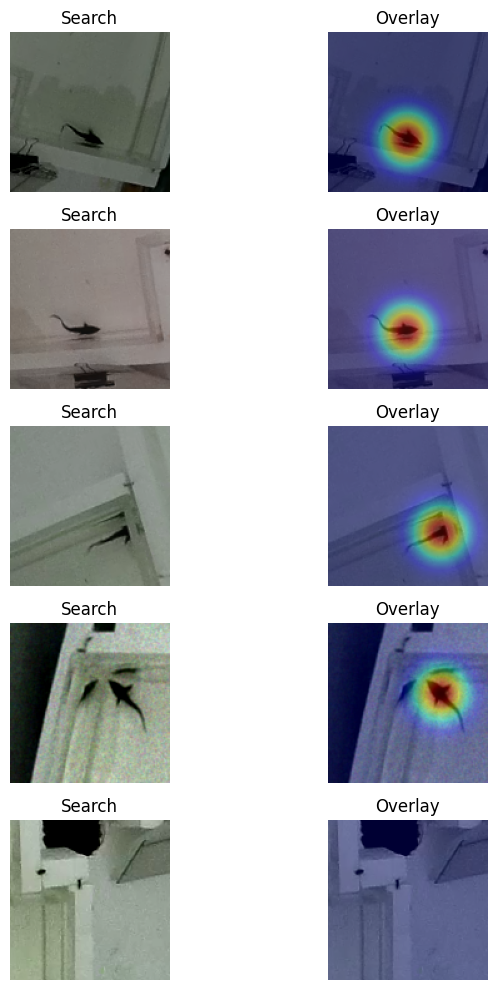

In [5]:

test_dataset(datasets[0]["train"], samples=5)

In [6]:
cache_dir = "../data/training/cache"

for dataset in datasets:
    cache_dataset(dataset, cache_dir, cache_multiplier=4)

Caching train for E7 set, pass 1:   0%|          | 0/6561 [00:00<?, ?it/s]

Caching train for E7 set, pass 2:   0%|          | 0/6561 [00:00<?, ?it/s]

Caching train for E7 set, pass 3:   0%|          | 0/6561 [00:00<?, ?it/s]

Caching train for E7 set, pass 4:   0%|          | 0/6561 [00:00<?, ?it/s]

Caching val for E7 set, pass 1:   0%|          | 0/729 [00:00<?, ?it/s]

Caching train for K9 set, pass 1:   0%|          | 0/7906 [00:00<?, ?it/s]

Caching train for K9 set, pass 2:   0%|          | 0/7906 [00:00<?, ?it/s]

Caching train for K9 set, pass 3:   0%|          | 0/7906 [00:00<?, ?it/s]

Caching train for K9 set, pass 4:   0%|          | 0/7906 [00:00<?, ?it/s]

Caching val for K9 set, pass 1:   0%|          | 0/879 [00:00<?, ?it/s]

Caching train for S1 set, pass 1:   0%|          | 0/2080 [00:00<?, ?it/s]

Caching train for S1 set, pass 2:   0%|          | 0/2080 [00:00<?, ?it/s]

Caching train for S1 set, pass 3:   0%|          | 0/2080 [00:00<?, ?it/s]

Caching train for S1 set, pass 4:   0%|          | 0/2080 [00:00<?, ?it/s]

Caching val for S1 set, pass 1:   0%|          | 0/232 [00:00<?, ?it/s]

Caching train for 4_per_23 set, pass 1:   0%|          | 0/3355 [00:00<?, ?it/s]

Caching train for 4_per_23 set, pass 2:   0%|          | 0/3355 [00:00<?, ?it/s]

Caching train for 4_per_23 set, pass 3:   0%|          | 0/3355 [00:00<?, ?it/s]

Caching train for 4_per_23 set, pass 4:   0%|          | 0/3355 [00:00<?, ?it/s]

Caching val for 4_per_23 set, pass 1:   0%|          | 0/373 [00:00<?, ?it/s]

Caching train for 5_per_12 set, pass 1:   0%|          | 0/6519 [00:00<?, ?it/s]

Caching train for 5_per_12 set, pass 2:   0%|          | 0/6519 [00:00<?, ?it/s]

Caching train for 5_per_12 set, pass 3:   0%|          | 0/6519 [00:00<?, ?it/s]

Caching train for 5_per_12 set, pass 4:   0%|          | 0/6519 [00:00<?, ?it/s]

Caching val for 5_per_12 set, pass 1:   0%|          | 0/725 [00:00<?, ?it/s]

In [7]:
cache_dir = "../data/training/cache"

dataset = CachedDetectionDataset(os.path.join(cache_dir, "E7", "train"))

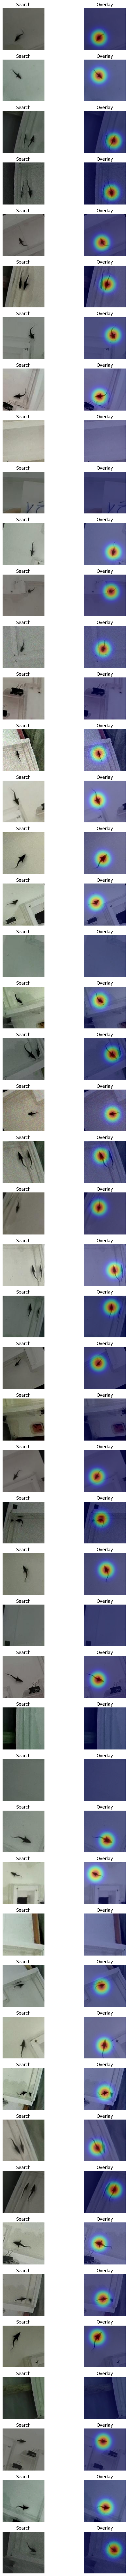

In [8]:
test_dataset(dataset, samples=50)